In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt_ALL_HIST.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(104547, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0108775051,Jersey top with narrow shoulder straps.,2
3,0110065001,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065002,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt_ALL_HIST.csv')
print(customers.shape)
customers.head()

(61900, 5)


,customer_id,FN,Active,age,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0.49,0
1,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,1
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,2
3,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,3
4,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
embeddings = model.encode(article_descriptions)

In [13]:
embeddings = torch.tensor(embeddings)

In [14]:
embeddings.shape

torch.Size([104547, 384])

In [15]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [16]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [17]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [18]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(61900, 384)
  (fc_1): Linear(in_features=771, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=104547, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [19]:
BATCH_SIZE = 1024

In [20]:
total_training_examples = pd.read_csv('data/final_train_set_ALL_HIST.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

61.0

In [21]:
total_dev_examples = pd.read_csv('data/final_dev_set_ALL_HIST.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

11.0

In [22]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [23]:
MAX_EPOCHS = 75

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_ALL_HIST.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_ALL_HIST.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_ALL_HIST.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            # optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|██████████| 61/61.0 [00:40<00:00,  1.51it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.40it/s]


Training loss: 8.659759503735865


100%|██████████| 11/11.0 [00:07<00:00,  1.44it/s]


Dev loss: 48.828485451015666


100%|██████████| 61/61.0 [00:40<00:00,  1.52it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.39it/s]


Training loss: 8.54870226833855


100%|██████████| 11/11.0 [00:07<00:00,  1.47it/s]


Dev loss: 48.2022836955872


100%|██████████| 61/61.0 [00:39<00:00,  1.53it/s]
100%|██████████| 61/61.0 [00:42<00:00,  1.42it/s]


Training loss: 8.3946058371302


100%|██████████| 11/11.0 [00:07<00:00,  1.42it/s]


Dev loss: 47.33340329006735


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.41it/s]


Training loss: 8.325914379606724


100%|██████████| 11/11.0 [00:07<00:00,  1.46it/s]


Dev loss: 46.94608308413702


100%|██████████| 61/61.0 [00:39<00:00,  1.54it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 8.148162713613187


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 45.94382145861325


100%|██████████| 61/61.0 [00:41<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.31it/s]


Training loss: 7.943822011624091


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 44.79163622877858


100%|██████████| 61/61.0 [00:40<00:00,  1.52it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.34it/s]


Training loss: 7.77357143814999


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 43.83166988718204


100%|██████████| 61/61.0 [00:39<00:00,  1.54it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 7.451984437316993


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 42.0183855592933


100%|██████████| 61/61.0 [00:41<00:00,  1.47it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 7.239317226625606


100%|██████████| 11/11.0 [00:07<00:00,  1.44it/s]


Dev loss: 40.819250895256424


100%|██████████| 61/61.0 [00:42<00:00,  1.43it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 7.201570758973647


100%|██████████| 11/11.0 [00:08<00:00,  1.31it/s]


Dev loss: 40.60641555661038


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 7.434455246933057


100%|██████████| 11/11.0 [00:08<00:00,  1.36it/s]


Dev loss: 41.919546345887795


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.37it/s]


Training loss: 6.749846262400292


100%|██████████| 11/11.0 [00:08<00:00,  1.31it/s]


Dev loss: 38.059344474638195


100%|██████████| 61/61.0 [00:41<00:00,  1.47it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.31it/s]


Training loss: 6.400160198057603


100%|██████████| 11/11.0 [00:08<00:00,  1.30it/s]


Dev loss: 36.087622177060084


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 6.70723262065832


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 37.819065332369284


100%|██████████| 61/61.0 [00:41<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.31it/s]


Training loss: 6.568777119724354


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 37.03837709154104


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 5.988863432703958


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 33.76850487195983


100%|██████████| 61/61.0 [00:41<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 5.954306317207694


100%|██████████| 11/11.0 [00:07<00:00,  1.48it/s]


Dev loss: 33.57365285435929


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:48<00:00,  1.27it/s]


Training loss: 5.864458212906402


100%|██████████| 11/11.0 [00:08<00:00,  1.32it/s]


Dev loss: 33.06703984140155


100%|██████████| 61/61.0 [00:42<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 5.317776044559016


100%|██████████| 11/11.0 [00:07<00:00,  1.43it/s]


Dev loss: 29.984545195682557


100%|██████████| 61/61.0 [00:42<00:00,  1.43it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 5.162472332043871


100%|██████████| 11/11.0 [00:08<00:00,  1.31it/s]


Dev loss: 29.10885747435923


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.30it/s]


Training loss: 5.604534977187248


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 31.60144972562312


100%|██████████| 61/61.0 [00:41<00:00,  1.47it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.37it/s]


Training loss: 5.171841181198884


100%|██████████| 11/11.0 [00:08<00:00,  1.37it/s]


Dev loss: 29.16168419714073


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.31it/s]


Training loss: 4.2459239519701635


100%|██████████| 11/11.0 [00:08<00:00,  1.31it/s]


Dev loss: 23.94085376452479


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 4.1911373502025695


100%|██████████| 11/11.0 [00:07<00:00,  1.42it/s]


Dev loss: 23.631936780610225


100%|██████████| 61/61.0 [00:40<00:00,  1.51it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.31it/s]


Training loss: 3.939452004871769


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 22.212796420255284


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 3.6632437533130555


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 20.655382431233203


100%|██████████| 61/61.0 [00:40<00:00,  1.51it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.39it/s]


Training loss: 3.524151001962591


100%|██████████| 11/11.0 [00:07<00:00,  1.45it/s]


Dev loss: 19.871101022179303


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.37it/s]


Training loss: 3.2743498464162206


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 18.462584759807257


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 3.5723526676405997


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 20.142888515845613


100%|██████████| 61/61.0 [00:40<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 3.3057380580131763


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 18.639568754874805


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.32it/s]


Training loss: 3.2040532017524486


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 18.066213626204824


100%|██████████| 61/61.0 [00:39<00:00,  1.54it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 3.075306372819694


100%|██████████| 11/11.0 [00:07<00:00,  1.41it/s]


Dev loss: 17.340268216208695


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.31it/s]


Training loss: 2.8262638004530998


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 15.936029262893685


100%|██████████| 61/61.0 [00:41<00:00,  1.47it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 2.696610078827052


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 15.204970293258748


100%|██████████| 61/61.0 [00:40<00:00,  1.51it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 2.6179835453557274


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 14.761630666562173


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 2.494247999545638


100%|██████████| 11/11.0 [00:07<00:00,  1.42it/s]


Dev loss: 14.063941626150028


100%|██████████| 61/61.0 [00:42<00:00,  1.42it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.29it/s]


Training loss: 2.3780683526700073


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 13.408856898367047


100%|██████████| 61/61.0 [00:41<00:00,  1.47it/s]
100%|██████████| 61/61.0 [00:48<00:00,  1.25it/s]


Training loss: 2.313220951406944


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 13.043211595198565


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.34it/s]


Training loss: 2.3638579760229455


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 13.328730981583195


100%|██████████| 61/61.0 [00:42<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.27it/s]


Training loss: 2.249797895736571


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 12.685597535625227


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 2.097007095262962


100%|██████████| 11/11.0 [00:08<00:00,  1.36it/s]


Dev loss: 11.824078994058786


100%|██████████| 61/61.0 [00:42<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.32it/s]


Training loss: 2.062740245812929


100%|██████████| 11/11.0 [00:07<00:00,  1.40it/s]


Dev loss: 11.630863656022983


100%|██████████| 61/61.0 [00:41<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.38it/s]


Training loss: 2.076343260535516


100%|██████████| 11/11.0 [00:08<00:00,  1.30it/s]


Dev loss: 11.707564932332705


100%|██████████| 61/61.0 [00:42<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.34it/s]


Training loss: 1.9429196497311692


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 10.955249254723936


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.34it/s]


Training loss: 1.9533865647323683


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 11.014267476492403


100%|██████████| 61/61.0 [00:41<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.38it/s]


Training loss: 1.864877892218422


100%|██████████| 11/11.0 [00:07<00:00,  1.45it/s]


Dev loss: 10.515206916407388


100%|██████████| 61/61.0 [00:42<00:00,  1.45it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 1.874744533853115


100%|██████████| 11/11.0 [00:07<00:00,  1.42it/s]


Dev loss: 10.570840466889035


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 1.9289797702475011


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 10.876648549673922


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 1.844766837814898


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 10.401809734081088


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 1.7626091493967084


100%|██████████| 11/11.0 [00:07<00:00,  1.44it/s]


Dev loss: 9.938559514270016


100%|██████████| 61/61.0 [00:42<00:00,  1.43it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.29it/s]


Training loss: 1.7036271043817524


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 9.60598631455916


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.42it/s]


Training loss: 1.647248487826888


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 9.288092675941371


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 1.7019620949001035


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 9.59659807563458


100%|██████████| 61/61.0 [00:42<00:00,  1.43it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.29it/s]


Training loss: 1.6741794764899283


100%|██████████| 11/11.0 [00:08<00:00,  1.35it/s]


Dev loss: 9.439944397406318


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.38it/s]


Training loss: 1.5978365068327822


100%|██████████| 11/11.0 [00:07<00:00,  1.40it/s]


Dev loss: 9.009480759058956


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 1.5388350557934294


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 8.676798137512597


100%|██████████| 61/61.0 [00:41<00:00,  1.47it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.37it/s]


Training loss: 1.5337018374441513


100%|██████████| 11/11.0 [00:07<00:00,  1.38it/s]


Dev loss: 8.647854230077698


100%|██████████| 61/61.0 [00:42<00:00,  1.43it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.29it/s]


Training loss: 1.534847922872072


100%|██████████| 11/11.0 [00:07<00:00,  1.45it/s]


Dev loss: 8.654316489868943


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.28it/s]


Training loss: 1.539739476513593


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 8.681897758807743


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.37it/s]


Training loss: 1.500930199445931


100%|██████████| 11/11.0 [00:07<00:00,  1.39it/s]


Dev loss: 8.463069716314731


100%|██████████| 61/61.0 [00:40<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.30it/s]


Training loss: 1.4408452432413672


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 8.124277696906598


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 1.4241756023844532


100%|██████████| 11/11.0 [00:08<00:00,  1.34it/s]


Dev loss: 8.030285096337916


100%|██████████| 61/61.0 [00:40<00:00,  1.52it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.38it/s]


Training loss: 1.4356684779350515


100%|██████████| 11/11.0 [00:07<00:00,  1.41it/s]


Dev loss: 8.095088247784632


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.29it/s]


Training loss: 1.4192516024933108


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 8.00252087760393


100%|██████████| 61/61.0 [00:40<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:46<00:00,  1.32it/s]


Training loss: 1.4115643734539076


100%|██████████| 11/11.0 [00:08<00:00,  1.33it/s]


Dev loss: 7.959176053634257


100%|██████████| 61/61.0 [00:41<00:00,  1.46it/s]
100%|██████████| 61/61.0 [00:47<00:00,  1.29it/s]


Training loss: 1.3988836275510526


100%|██████████| 11/11.0 [00:07<00:00,  1.38it/s]


Dev loss: 7.887675036018415


100%|██████████| 61/61.0 [00:40<00:00,  1.52it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.40it/s]


Training loss: 1.3768705155429624


100%|██████████| 11/11.0 [00:07<00:00,  1.45it/s]


Dev loss: 7.763553007115083


100%|██████████| 61/61.0 [00:39<00:00,  1.53it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.40it/s]


Training loss: 1.3813440010428235


100%|██████████| 11/11.0 [00:07<00:00,  1.40it/s]


Dev loss: 7.788776978006084


100%|██████████| 61/61.0 [00:42<00:00,  1.44it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.34it/s]


Training loss: 1.3576273110532993


100%|██████████| 11/11.0 [00:07<00:00,  1.38it/s]


Dev loss: 7.655049239770379


100%|██████████| 61/61.0 [00:40<00:00,  1.52it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.33it/s]


Training loss: 1.3386014567977584


100%|██████████| 11/11.0 [00:07<00:00,  1.39it/s]


Dev loss: 7.54777101255067


100%|██████████| 61/61.0 [00:40<00:00,  1.49it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.40it/s]


Training loss: 1.3197848170562398


100%|██████████| 11/11.0 [00:07<00:00,  1.41it/s]


Dev loss: 7.44167245179279


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.35it/s]


Training loss: 1.3081663776946184


100%|██████████| 11/11.0 [00:07<00:00,  1.42it/s]


Dev loss: 7.376161302541162


100%|██████████| 61/61.0 [00:41<00:00,  1.48it/s]
100%|██████████| 61/61.0 [00:45<00:00,  1.34it/s]


Training loss: 1.3092577612265246


100%|██████████| 11/11.0 [00:07<00:00,  1.40it/s]


Dev loss: 7.382315122966102


100%|██████████| 61/61.0 [00:40<00:00,  1.50it/s]
100%|██████████| 61/61.0 [00:44<00:00,  1.36it/s]


Training loss: 1.2999367285314014


100%|██████████| 11/11.0 [00:07<00:00,  1.41it/s]


Dev loss: 7.329758015676239


100%|██████████| 61/61.0 [00:40<00:00,  1.51it/s]
100%|██████████| 61/61.0 [00:43<00:00,  1.41it/s]


Training loss: 1.29354252286797


100%|██████████| 11/11.0 [00:07<00:00,  1.48it/s]

Dev loss: 7.293703968439364


In [24]:
training_losses[-1], dev_losses[-1]

(1.29354252286797, 7.293703968439364)

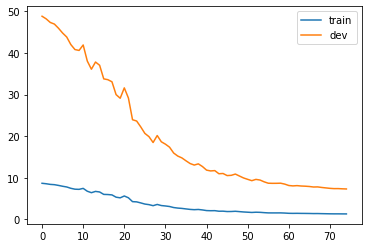

In [25]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [65]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_ALL_HIST.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 61/61.0 [00:39<00:00,  1.54it/s]


In [66]:
predictions = torch.concat(predictions)

In [67]:
predictions.shape

torch.Size([61900, 12])

In [68]:
actuals = pd.read_csv('data/final_train_set_ALL_HIST.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

61900

In [69]:
mapk(actuals, predictions.tolist(), 12)

0.9434317515327293

🤯

#### Dev (new)

In [55]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set_ALL_HIST.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 11/11.0 [00:07<00:00,  1.48it/s]


In [56]:
predictions = torch.concat(predictions)

In [57]:
predictions.shape

torch.Size([10978, 12])

In [58]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [59]:
mapk(actuals, predictions.tolist(), 12)

2.192982456140351e-05

#### Dev (old)

In [60]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

 82%|████████▏ | 9/11.0 [00:06<00:01,  1.49it/s]


In [61]:
predictions = torch.concat(predictions)

In [62]:
predictions.shape

torch.Size([9120, 12])

In [63]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [64]:
mapk(actuals, predictions.tolist(), 12)

0.0

#### Test (new)

In [78]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set_ALL_HIST.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [79]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set_ALL_HIST.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 11/11.0 [00:06<00:00,  1.59it/s]


In [80]:
predictions = torch.concat(predictions)

In [81]:
predictions.shape

torch.Size([10308, 12])

In [82]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [83]:
mapk(actuals, predictions.tolist(), 12)

0.0

In [84]:
# Number of unique items in predictions
len(predictions.unique())

11238

In [85]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

#### Test (old)

In [70]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [71]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:05<00:00,  1.56it/s]


In [72]:
predictions = torch.concat(predictions)

In [73]:
predictions.shape

torch.Size([8733, 12])

In [74]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [75]:
mapk(actuals, predictions.tolist(), 12)

3.5783808542310774e-05

In [76]:
# Number of unique items in predictions
len(predictions.unique())

10366

In [77]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

- Using full training set leads to very poor performance on the dev and test sets used in the previous run
- Performance on the new dev/tests sets is also poor and even 0 for the test set, suggesting that the model is more susceptible to overfitting the training set when all historical data is used
- One hypothesis for this is the fact that fashion trends change over time so purchasing patterns from 1-2 years ago are not relevant for current purchase patterns and this may be confusing the model
- One solution may be to add example age as a feature so the model learns to place less importance on observations from the past 